In [1]:
reset -fs

In [2]:
import numpy as np
import pandas as pd
import os
import glob
import pickle
import gzip
import h5py
import dl_functions
from IPython.display import display
from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, Input, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.
//anaconda/envs/wellio/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
InceptionV3(weights='imagenet')

In [4]:
in_v3 = InceptionV3(weights='imagenet')

### Take a look at the InceptionV3 architecture.

In [5]:
in_v3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_95 (Conv2D)               (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
batch_normalization_95 (BatchNor (None, 149, 149, 32)  96                                           
____________________________________________________________________________________________________
activation_95 (Activation)       (None, 149, 149, 32)  0                                            
___________________________________________________________________________________________

### InceptionV3 expects images of size 299.

In [6]:
IMG_SIZE = 299

### Folder where images are downloaded.

In [7]:
ok_images='/Users/carles/Downloads/data/ok'

In [8]:
nok_images='/Users/carles/Downloads/data/nok'

### Pre-processing images.

In [9]:
X = np.vstack((dl_functions.normalize_images_array(ok_images, IMG_SIZE), dl_functions.normalize_images_array(nok_images, IMG_SIZE)))

### Creating labels.

In [10]:
y = np.vstack((np.array([1]*(len(X)/2)).reshape((len(X)/2), 1), np.array([0]*(len(X)/2)).reshape((len(X)/2), 1)))

### Train, test split.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
y_train_sparse = np_utils.to_categorical(y_train, 2)

In [13]:
y_test_sparse = np_utils.to_categorical(y_test, 2)

### Using InceptionV3 to pre-train a model.

In [14]:
base_model = InceptionV3(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalMaxPooling2D()(x)
# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# Add a logistic layer - we have 2 classes.
predictions = Dense(2, activation='softmax')(x)

In [15]:
# This is the model we will train.
model = Model(input=base_model.input, output=predictions)

/anaconda/envs/wellio/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app


In [16]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_189 (Conv2D)              (None, None, None, 32 864                                          
____________________________________________________________________________________________________
batch_normalization_189 (BatchNo (None, None, None, 32 96                                           
____________________________________________________________________________________________________
activation_189 (Activation)      (None, None, None, 32 0                                            
___________________________________________________________________________________________

In [18]:
model.fit(X_train, y_train_sparse, batch_size=128, epochs=2, validation_split=0.1, verbose=1)

Train on 12 samples, validate on 2 samples
Epoch 1/2
12/12 [==============================] - 24s - loss: 1.9674 - acc: 0.4167 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 2/2
12/12 [==============================] - 10s - loss: 9.3510 - acc: 0.4167 - val_loss: 8.0151 - val_acc: 0.5000


In [19]:
score = model.evaluate(X_test, y_test_sparse, verbose=True)

6/6 [==============================] - 1s


In [20]:
print('Test loss: {:0,.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Test loss: 5.3434
Test accuracy: 66.67%


In [21]:
predicted_images = []
for i in model.predict(X_test):
    predicted_images.append(np.where(np.max(i) == i)[0])

dl_functions.py:254: RuntimeWarning: invalid value encountered in divide
  'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),


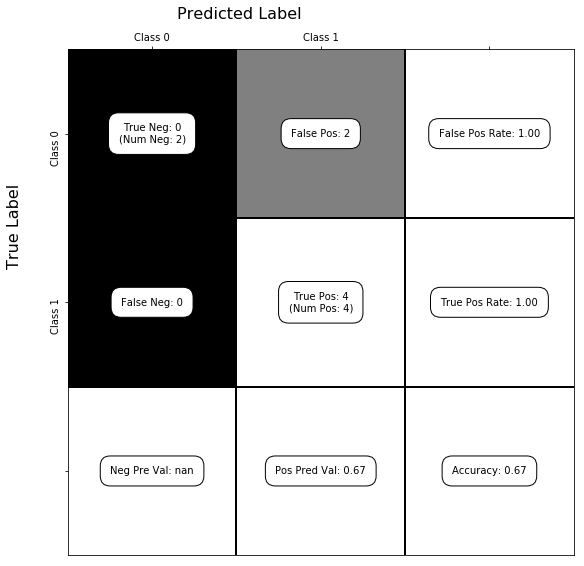

In [22]:
dl_functions.show_confusion_matrix(confusion_matrix(y_test, predicted_images), ['Class 0', 'Class 1'])